NOTE to self : Use COLAB

In [16]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import torch
from sentence_transformers import SentenceTransformer
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
Tesla T4


---

### 📘 What This Dataset Is and What It Contains

- **`maartengr/arxiv_nlp`** is a curated subset of arXiv papers focused **only on the field of NLP**  
  (the arXiv category **cs.CL – Computation and Language**).

- It contains **tens of thousands of papers** published between **1991 and 2024**.

- Each record represents **one arXiv paper** and includes:
  - **Title** – the paper’s name  
  - **Abstracts** – the full abstract text  
  - **Years** – publication year  
  - **Categories** – always `"Computation and Language"` (because this dataset is filtered to cs.CL only)

- The dataset is already cleaned and structured, so you don’t download PDFs or raw text — only metadata and text fields ready for NLP tasks.

---


In [17]:
# Load data from huggingface
from datasets import load_dataset
dataset = load_dataset("maartengr/arxiv_nlp")["train"]
# Extract specific metadata
abstracts = dataset["Abstracts"]
df = pd.DataFrame(dataset)
years = dataset["Years"]
categories = dataset["Categories"]
titles = dataset["Titles"]
print(df.shape)
print(df.info())
df.head()



(44949, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44949 entries, 0 to 44948
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Titles      44949 non-null  object
 1   Abstracts   44949 non-null  object
 2   Years       44949 non-null  int64 
 3   Categories  44949 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.4+ MB
None


,Titles,Abstracts,Years,Categories
0,Introduction to Arabic Speech Recognition Usin...,In this paper Arabic was investigated from t...,2007,Computation and Language
1,Arabic Speech Recognition System using CMU-Sph...,In this paper we present the creation of an ...,2007,Computation and Language
2,On the Development of Text Input Method - Less...,Intelligent Input Methods (IM) are essential...,2007,Computation and Language
3,Network statistics on early English Syntax: St...,This paper includes a reflection on the role...,2007,Computation and Language
4,Segmentation and Context of Literary and Music...,"We test a segmentation algorithm, based on t...",2007,Computation and Language


---

### 🔍 What this code does

1. Loads the **ArXiv NLP dataset** from HuggingFace.
2. Loads a **very small SentenceTransformer model** (`all-MiniLM-L6-v1`) to create text embeddings.
3. Converts each abstract into a **384-dimensional embedding vector**.
4. Applies **PCA (Principal Component Analysis)** to reduce the embeddings from 384 dimensions down to **5 dimensions**.
   - PCA is used instead of UMAP because it is **much faster on CPU**.
5. Prints the original embedding shape and the reduced shape.

### 🧾 What the output means

- `Original shape: (10000, 384)`  
  → We created embeddings for 10,000 documents, each with 384 features.

- `Reduced shape: (10000, 5)`  
  → PCA compressed each embedding to 5 numbers while keeping the main structure.

These reduced embeddings can later be used for **clustering**, **visualization**, or **topic modeling** (like BERTopic), but they are much lighter and faster to process.

---

### 🔍 What does it mean to embed the articles?
Embedding an article means converting its text into a vector of numbers that captures its meaning.  
Similar articles get similar vectors; different topics get distant vectors.  
This lets us compare, cluster, or visualize the articles mathematically.

### 🧠 How does the model create these embeddings?
1. The model was pretrained on millions of texts, so it already understands language patterns.
2. It splits the article into tokens (words or subwords).
3. A transformer model processes how each word relates to the others using attention.
4. It combines everything into one final vector (e.g., 384 numbers) that represents the meaning of the whole article.

In short: the model gives each article a **numerical “meaning fingerprint”** based on what it learned during pretraining.

---

In [18]:
import torch
import numpy as np
from sentence_transformers import SentenceTransformer
from umap import UMAP

# Make list of documents
abstract_list = list(dataset["Abstracts"])

# Device
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# Embedding model on device
model = SentenceTransformer("all-MiniLM-L6-v1", device=device)

# Create embeddings
emb = model.encode(
    abstract_list,
    batch_size=128,
    show_progress_bar=True,
    convert_to_numpy=True
)

# UMAP (same style as your textbook)
umap_model = UMAP(
    n_neighbors=15,
    n_components=5,
    min_dist=0.0,
    metric="cosine"
)

# Reduce embeddings
reduced_embeddings = umap_model.fit_transform(emb)

print("Original shape:", emb.shape)
print("Reduced shape:", reduced_embeddings.shape)


Using device: cuda


Batches:   0%|          | 0/352 [00:00<?, ?it/s]

Original shape: (44949, 384)
Reduced shape: (44949, 5)


In [19]:
print("embeddings of frist article in the dataset: ")
print(emb[0])
print("-"*100)
print("reduced_embeddings of frist article in the dataset: ")
print(reduced_embeddings[0])


embeddings of frist article in the dataset: 
[-7.55249932e-02  1.29333613e-02 -5.59621714e-02 -9.88867059e-02
 -9.07694474e-02  8.44007209e-02 -1.08201718e-02 -1.12512901e-01
 -7.58438511e-03  3.07803396e-02  9.01785679e-03 -1.00357970e-02
  1.73429430e-01 -7.52512738e-02  2.96915248e-02 -4.51970622e-02
  5.13760969e-02  1.20635508e-02 -2.41901469e-03 -9.34470445e-02
  6.67219236e-02  1.18206486e-01 -3.44792381e-03  1.97267048e-02
  9.69223306e-03  9.50863643e-04 -7.34077245e-02 -5.13726771e-02
  2.58665141e-02 -4.61284332e-02  5.54661602e-02 -3.74621600e-02
  9.44435447e-02 -7.44880037e-03 -1.93500500e-02  2.51328684e-02
 -1.34507753e-02  1.34454817e-02 -3.48477364e-02 -1.55143868e-02
  3.28522399e-02 -3.48281153e-02 -4.47095139e-03 -3.89306748e-04
  5.65940551e-02  4.61866781e-02  1.91393718e-02  5.52220419e-02
  1.14194624e-01  2.84770746e-02 -4.05261926e-02  1.68827269e-02
  4.01734300e-02 -7.67709571e-04 -5.97193874e-02 -4.01056632e-02
  3.37084080e-03 -3.52158491e-03  1.18948193e

In [20]:
from hdbscan import HDBSCAN

# Instantiate HDBSCAN model
hdbscan_model = HDBSCAN(min_cluster_size=15, metric='euclidean')

# Fit on the reduced UMAP embeddings
hdbscan_model.fit(reduced_embeddings)

# Cluster labels
labels = hdbscan_model.labels_
print(labels)

[ -1  -1  -1 ...  -1 181  -1]


In [21]:
import seaborn as sns
import pandas as pd
import numpy as np
from umap import UMAP

# Reduce original embeddings to 2 dimensions for visualization
umap_2d = UMAP(
    n_neighbors=15,
    n_components=2,
    min_dist=0.0,
    metric='cosine'
).fit_transform(emb)

# Create DataFrame: x, y, cluster
tmp = pd.DataFrame(
    np.hstack([umap_2d, labels.reshape(-1,1)]),
    columns=["x", "y", "cluster"]
).sort_values("cluster")

# Convert cluster values to strings for coloring
tmp.cluster = tmp.cluster.astype(int).astype(str)

print("number of clusters plus NoiseCluster(-1) =", tmp["cluster"].nunique())
tmp.head()

number of clusters plus NoiseCluster(-1) = 351


,x,y,cluster
12030,3.281560,7.005876,-1
23066,-4.137316,14.109712,-1
23036,-0.872579,9.500083,-1
23037,-0.482952,13.124200,-1
23038,-3.319022,12.110134,-1


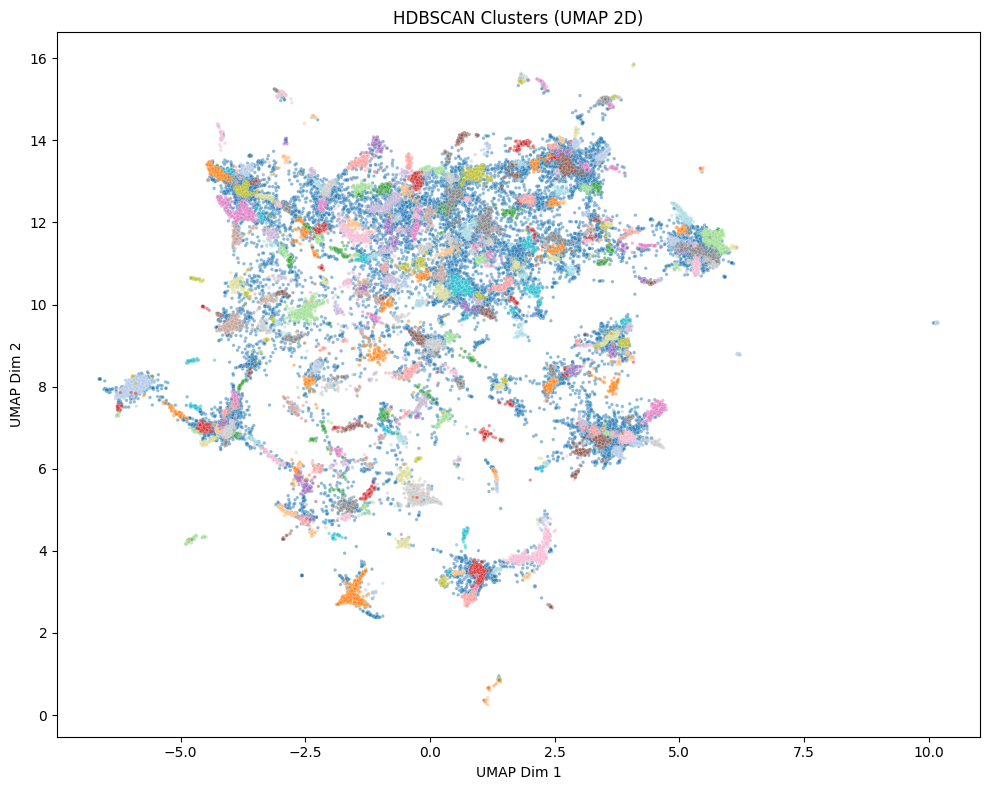

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))

sns.scatterplot(
    data=tmp,
    x="x",
    y="y",
    hue="cluster",
    palette="tab20",
    s=6,
    alpha=0.5,
    legend=False    # ← no legend
)

plt.title("HDBSCAN Clusters (UMAP 2D)")
plt.xlabel("UMAP Dim 1")
plt.ylabel("UMAP Dim 2")

plt.tight_layout()
plt.show()




---

# 📘 **Text Clustering Workflow — What We Accomplished**

---

## 🔹 **1. Load & Prepare the Dataset**

* Pulled the ArXiv NLP dataset.
* Extracted **abstracts**, **years**, **categories**, and **titles**.
* These texts formed the foundation for the entire pipeline.

---

## 🤖 **2. Convert Text → Embeddings**

* Used a **SentenceTransformer (MiniLM)** to transform each abstract into a **semantic vector**.
* These embeddings capture the meaning of each document.

---

## 🔻 **3. Reduce Dimensionality with UMAP**

* Original embeddings were high-dimensional (hundreds of values).
* Applied **UMAP** to compress them into **5 dimensions**.
* This avoids the *curse of dimensionality* and improves clustering.

---

## 🧩 **4. Cluster with HDBSCAN**

* Used **HDBSCAN**, a density-based algorithm that:

  * Automatically finds cluster shapes
  * Detects outliers (noise)
  * Does *not* require you to choose the number of clusters
* Result: a set of meaningful cluster labels for each document.

---

## 🎨 **5. Visualize Embeddings in 2D**

* Used UMAP again (this time **n_components = 2**) for plotting.
* Plotted all documents in a scatter plot, colored by cluster.
* Allowed us to *see* how documents group together.

---

## 🔍 **6. Inspect Cluster Meaning**

* Sampled documents from selected clusters.
* Observed strong semantic themes—for example:

  * sarcasm detection
  * language modeling
  * NLP techniques
* Confirmed that HDBSCAN produced coherent groups.

---

## 🧠 **7. Prepare for Topic Modeling**

* After clustering, the next step (as in the textbook) is extracting **topic descriptions** from clusters.
* This leads to **BERTopic** or similar topic-modeling approaches.

---

# ⭐ **End Result**

You now have a full modern NLP clustering pipeline:
**Embeddings → UMAP → HDBSCAN → 2D Visualization → Human Interpretation.**

Beautiful, modular, and completely aligned with the textbook.

---




### Next step — build the BERTopic pipeline (clean & textbook-style)

Below is a short, simple implementation that follows the textbook pipeline:  
1. embedding model → 2. UMAP for reduction → 3. HDBSCAN for clustering → 4. CountVectorizer → 5. c-TF-IDF → 6. (optional) KeyBERT-inspired representation.  
It uses GPU for embeddings when available and keeps everything minimal so you can paste it into your notebook.


In [23]:
pip install bertopic

In [24]:
# BERTopic pipeline (textbook-style, minimal)
import torch
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from sklearn.feature_extraction.text import CountVectorizer
from bertopic import BERTopic
from bertopic.representation import KeyBERTInspired
from bertopic.vectorizers import ClassTfidfTransformer

# device-aware embedding model
device = "cuda" if torch.cuda.is_available() else "cpu"
embedding_model = SentenceTransformer("all-MiniLM-L6-v1", device=device)


In [25]:

# dimensionality reduction (matches textbook)
umap_model = UMAP(n_neighbors=15, n_components=5, metric="cosine", min_dist=0.0)

# clustering
hdbscan_model = HDBSCAN(min_cluster_size=15, metric="euclidean", core_dist_n_jobs=4)



### What This Part of the Pipeline Does

This section assembles the *topic representation* part of BERTopic — the components that turn raw clustered documents into human-readable topics.

---

#### **1. CountVectorizer — Tokenizing & Counting Words**
```python
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))
````

* Converts each document into a bag-of-words matrix.
* Removes common English stopwords.
* Uses **1-grams and 2-grams**, so topics can include both single words and short phrases.

---

#### **2. Class-TF-IDF — Scoring Words Inside Each Cluster**

```python
ctfidf_model = ClassTfidfTransformer()
```

* Computes special TF-IDF scores **per cluster**, not per document.
* Highlights words that are *characteristic* for each topic.
* This is how BERTopic decides what the topic keywords are.

---

#### **3. KeyBERTInspired — Improving the Topic Labels**

```python
representation_model = KeyBERTInspired()
```

* Optionally refines the topic words using semantic similarity.
* Produces cleaner, more meaningful topic labels.

---

#### **4. Assemble Everything into BERTopic**

```python
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    verbose=False
)
```

You plug the components together:

* **Embeddings → UMAP → HDBSCAN → CountVectorizer → c-TF-IDF → (Optional) KeyBERT**
* This forms the full customizable BERTopic pipeline.

---

#### **5. Fit the Topic Model**

```python
topics, probs = topic_model.fit_transform(abstract_list)
```

* Embeds texts
* Reduces dimensions
* Clusters them
* Builds topic keywords
* Returns topic assignments + their probabilities

---

```
```


In [29]:

# tokenization / vectorization
vectorizer_model = CountVectorizer(stop_words="english", ngram_range=(1, 2))

# class-TF-IDF for topic scoring
ctfidf_model = ClassTfidfTransformer()

# optional representation model (gives nicer topic keywords)
representation_model = KeyBERTInspired()

# assemble BERTopic with the components
topic_model = BERTopic(
    embedding_model=embedding_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    vectorizer_model=vectorizer_model,
    ctfidf_model=ctfidf_model,
    representation_model=representation_model,
    verbose=False
)


In [30]:
# fit on your document list (e.g., 'abstract_list' from earlier)
topics, probs = topic_model.fit_transform(abstract_list)

probability = 0.0 for outlier
In BERTopic Outliers always get prob=0.0 Because they aren't assigned to any stable topic.
This is correct behavior.

In [31]:
for i in range(10):
  print(f"Document {i+1} belongs to topic {topics[i]} with probability {probs[i]}")

Document 1 belongs to topic -1 with probability 0.0
Document 2 belongs to topic -1 with probability 0.0
Document 3 belongs to topic -1 with probability 0.0
Document 4 belongs to topic -1 with probability 0.0
Document 5 belongs to topic 47 with probability 0.36878671497958343
Document 6 belongs to topic 272 with probability 1.0
Document 7 belongs to topic -1 with probability 0.0
Document 8 belongs to topic -1 with probability 0.0
Document 9 belongs to topic 54 with probability 0.4835514250072117
Document 10 belongs to topic -1 with probability 0.0


In [49]:
print("what each topic id corresponds to ?")
tmp2 = topic_model.get_topics()

for i in range(3):
    if i not in tmp2:
        print(f"topic {i+1}: (no such topic)")
        print("-" * 100)
        continue

    print(f"topic {i+1}: has the following words as its keywords:")

    # extract word + score
    g = [(t[0], float(t[1])) for t in tmp2[i]]

    for p in g:
        print(f"  ({p[0]}) with C-TFIDF {p[1]}")

    print("-" * 100)


what each topic id corresponds to ?
topic 1: has the following words as its keywords:
  (abstractive text) with C-TFIDF 0.430914044380188
  (extractive) with C-TFIDF 0.4030616283416748
  (summarization systems) with C-TFIDF 0.3898945748806
  (summarization models) with C-TFIDF 0.36866632103919983
  (abstractive summarization) with C-TFIDF 0.3609640598297119
  (document summarization) with C-TFIDF 0.36043453216552734
  (extractive summarization) with C-TFIDF 0.3522854447364807
  (abstractive summaries) with C-TFIDF 0.34827521443367004
  (summarization model) with C-TFIDF 0.34509730339050293
  (text summarization) with C-TFIDF 0.333077609539032
----------------------------------------------------------------------------------------------------
topic 2: has the following words as its keywords:
  (language processing) with C-TFIDF 0.45963090658187866
  (word embeddings) with C-TFIDF 0.45745375752449036
  (word embedding) with C-TFIDF 0.44197744131088257
  (bias nlp) with C-TFIDF 0.42815798

In [42]:
tmp2

{-1: [('language models', np.float32(0.5060572)),
  ('natural language', np.float32(0.43502402)),
  ('large language', np.float32(0.42661518)),
  ('corpus', np.float32(0.41766354)),
  ('languages', np.float32(0.3896683)),
  ('multilingual', np.float32(0.38357466)),
  ('speech', np.float32(0.37783274)),
  ('language', np.float32(0.33631107)),
  ('dialogue', np.float32(0.31281614)),
  ('semantic', np.float32(0.28242692))],
 0: [('abstractive text', np.float32(0.43091404)),
  ('extractive', np.float32(0.40306163)),
  ('summarization systems', np.float32(0.38989457)),
  ('summarization models', np.float32(0.36866632)),
  ('abstractive summarization', np.float32(0.36096406)),
  ('document summarization', np.float32(0.36043453)),
  ('extractive summarization', np.float32(0.35228544)),
  ('abstractive summaries', np.float32(0.3482752)),
  ('summarization model', np.float32(0.3450973)),
  ('text summarization', np.float32(0.3330776))],
 1: [('language processing', np.float32(0.4596309)),
  ('w

In [50]:
print("Representative documents for each topic:\n")

for topic_id in range(10):
    try:
        docs = topic_model.get_representative_docs(topic_id)
    except KeyError:
        print(f"Topic {topic_id}: (no such topic)")
        print("-" * 100)
        continue

    print(f"Topic {topic_id}:")
    print("Top representative documents:\n")

    for i, d in enumerate(docs):
        preview = d[:200].replace("\n", " ")  # shorten long abstracts
        print(f"  Doc {i+1}: {preview}...")

    print("-" * 100)


Representative documents for each topic:

Topic 0:
Top representative documents:

  Doc 1:   We propose a new length-controllable abstractive summarization model. Recent state-of-the-art abstractive summarization models based on encoder-decoder models generate only one summary per source te...
  Doc 2:   Despite significant progress, state-of-the-art abstractive summarization methods are still prone to hallucinate content inconsistent with the source document. In this paper, we propose Constrained A...
  Doc 3:   Abstractive text summarization aims at compressing the information of a long source document into a rephrased, condensed summary. Despite advances in modeling techniques, abstractive summarization m...
----------------------------------------------------------------------------------------------------
Topic 1:
Top representative documents:

  Doc 1:   Machine learning models are trained to find patterns in data. NLP models can inadvertently learn socially undesirable patterns 

### Check out topic frequencies

In [51]:
topic_model.get_topic_freq()

,Topic,Count
0,-1,16603
28,0,700
86,1,628
39,2,571
43,3,562
...,...,...
253,351,15
335,352,15
276,353,15
88,354,15


### Check out C-TFIDF

In [52]:
import pandas as pd

# 1. Extract sparse cTFIDF matrix
ctfidf = topic_model.c_tf_idf_

# 2. Get vocabulary words
vocab = topic_model.vectorizer_model.get_feature_names_out()

# 3. Convert to dense DataFrame
ctfidf_df = pd.DataFrame(ctfidf.toarray(), columns=vocab)

# 4. Add topic ID as a column
ctfidf_df['topic'] = ctfidf_df.index

ctfidf_df

,00,00 09,00 10,00 17,00 328,00 38,00 58,00 66,00 74,00 75,...,zyrian,zyrian furthermore,zyrian northern,zyrian skolt,zyx,zyx order,zyz0000,zyz0000 finbert,zzz47zzz,zzz47zzz pretrained
0,0.000028,0.0,0.0,0.000003,0.000003,0.000003,0.0,0.000003,0.0,0.0,...,0.000006,0.0,0.000003,0.000003,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000057,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000058,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
352,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
353,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
354,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
355,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


---

## 📘 Topic Modeling Workflow — Summary of What We Built

### **1. Generated Document Embeddings**

We used a **SentenceTransformer** model (`all-MiniLM-L6-v2`) to convert each document into a dense vector.
These embeddings capture semantic meaning → similar documents get similar vectors.

---

### **2. Reduced Embeddings with UMAP**

UMAP compressed high-dimensional embeddings into a smaller space (e.g., 5D) while preserving structure.
This step makes clustering easier, faster, and more stable.

---

### **3. Clustered Documents with HDBSCAN**

HDBSCAN grouped reduced embeddings into topic clusters.

* Each cluster → one potential topic
* `-1` = outliers / documents that don’t fit any cluster
* Produces soft probabilities (how well each document fits its cluster)

---

### **4. Vectorized Text with CountVectorizer**

We transformed text into token counts (1–2 grams).
This vocabulary is used for computing topic-word importance.

---

### **5. Built Topic Representations with c-TF-IDF**

The **Class-TF-IDF** model computed how important each word is for each topic.
This gives **topic-word weights**, not probabilities.
Higher scores = more representative words.

---

### **6. (Optional) Refined Keywords with KeyBERTInspired**

This step improved topic labeling by using embeddings to refine keyword quality.

---

### **7. Fit the Full BERTopic Pipeline**

We assembled all components into a custom BERTopic model and ran:

```python
topics, probs = topic_model.fit_transform(documents)
```

This produced:

* `topics` → topic ID for each document
* `probs` → the strength/confidence of assignment

---

### **8. Explored Model Outputs**

We inspected:

* **Topic-word lists** via `get_topics()`
* **Representative documents** via `get_representative_docs()`
* Full **c-TF-IDF matrix** (topics × vocabulary)
* **Topic frequencies** and cluster sizes
* Visualization-friendly UMAP 2D coordinates

---
